# Winner World Cup 2022 Prediction ⚽

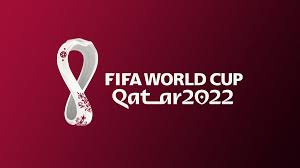

## Install and Import Necessary Libraries

In [64]:
# pip install -qU pip sagemaker pandas numpy
# !pip install s

In [83]:
import sagemaker, boto3, re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import s3_input,  Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import Rule, rule_configs
from sagemaker.serializers import CSVSerializer

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
df = pd.read_csv('../Data/engineered_data.csv')
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,rank_difference,average_rank,point_difference,score_difference,is_won,is_stake
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,No,Win,71.088608,71.755319,70.677528,75.38481,74.887342,70.776471,75.347872,74.980851,37,40.5,0,2,1,True
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,1,Friendly,Maceió,Brazil,False,No,Draw,71.088608,71.755319,70.677528,75.38481,74.887342,70.776471,75.347872,74.980851,-6,11.0,0,0,0,False
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,0,FIFA World Cup qualification,Quito,Ecuador,False,No,Win,71.088608,71.755319,70.677528,75.38481,74.887342,70.776471,75.347872,74.980851,-59,64.5,0,5,1,True
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,0,Friendly,Conakry,Guinea,False,No,Win,71.088608,71.755319,70.677528,75.38481,74.887342,70.776471,75.347872,74.980851,-21,75.5,0,1,1,False
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,No,Lose,71.088608,71.755319,70.677528,75.38481,74.887342,70.776471,75.347872,74.980851,62,36.0,0,-2,0,True


## Model

### Data

In [4]:
X = df[['is_won', 'average_rank', 'rank_difference', 'point_difference']]

In [5]:
role = get_execution_role()
sess = Session()
region = boto3.Session().region_name
bucket_name = 'sm-qwc22'
prefix = 'classifier_qwc22_wnr'

In [6]:
train_data, validation_data, test_data = np.split(X.sample(frac = 1, random_state = 123), [int(0.8 * len(X)), int(0.95 * len(X))])
train_data.shape, validation_data.shape, test_data.shape

((19136, 4), (3588, 4), (1197, 4))

In [7]:
train_data.to_csv('train_data.csv', index = False, header = False)
boto3.Session().resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "train", 'train_data.csv')).upload_file('train_data.csv')
s3_input_train = TrainingInput('s3://{0}/{1}/train'.format(bucket_name, prefix), content_type = 'csv')

In [8]:
validation_data.to_csv('validation_data.csv', index = False, header = False)
boto3.Session().resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "validation", 'validation_data.csv')).upload_file('validation_data.csv')
s3_input_validation = TrainingInput('s3://{0}/{1}/validation'.format(bucket_name, prefix), content_type = 'csv')

In [9]:
test_data.to_csv('test_data.csv', index = False, header = False)
boto3.Session().resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "test", 'test_data.csv')).upload_file('test_data.csv')
s3_input_test = TrainingInput('s3://{0}/{1}/test'.format(bucket_name, prefix), content_type = 'csv')

In [10]:
s3_model_output_location = r's3://{0}/model'.format(bucket_name)

In [11]:
# !aws s3 ls {bucket_name}/{prefix}/train --recursive
# !aws s3 ls {bucket_name}/{prefix}/validation --recursive
# !aws s3 ls {bucket_name}/{prefix}/test --recursive

### Training

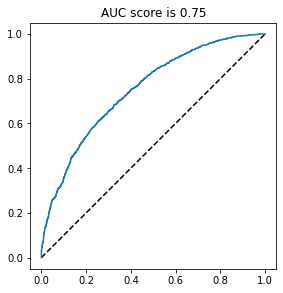

In [12]:
# Training locally with XGBClassifier

!pip install xgboost -q
from xgboost import XGBClassifier

x, y = X.loc[:,['average_rank', 'rank_difference', 'point_difference']], X['is_won']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 1)

model = XGBClassifier(n_estimators = 1000, learning_rate = 0.01, random_state = 42)
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)
plt.savefig('../Images/Local XGBClassifier ROC-CORVE.png')

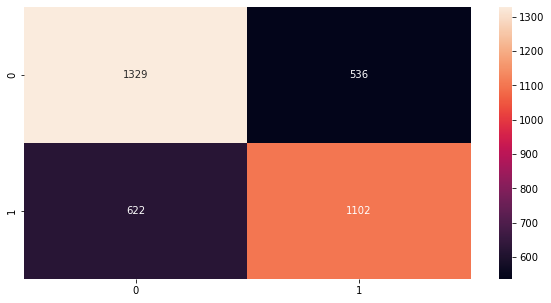

<Figure size 432x288 with 0 Axes>

In [23]:
# Confusion_Matrix
plt.figure(figsize=(10, 5))
cm = confusion_matrix(y_test, np.where(model.predict_proba(X_test)[:,1] > 0.5, 1, 0))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()
plt.savefig('../Images/Local XGBClassifier Confusion Maxtrix.png')

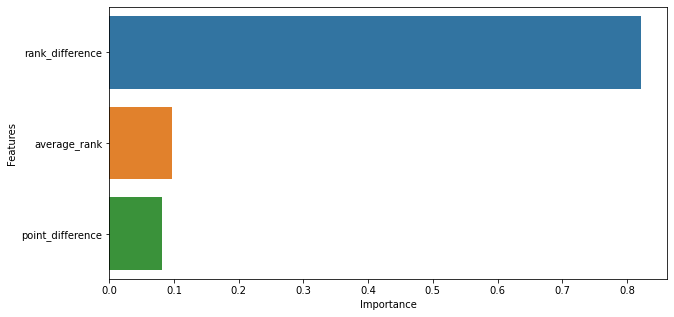

<Figure size 432x288 with 0 Axes>

In [14]:
feat_imp_df = pd.DataFrame(model.feature_importances_, columns = ['Importance'])
feat_imp_df['Features'] = X_test.columns

plt.figure(figsize = (10, 5))
sns.barplot(x = 'Importance', y = 'Features', data = feat_imp_df.sort_values(by = ['Importance'], ascending = False).head(50))
plt.show()
plt.savefig('../Images/Local XGBClassifier Feature_Importnace.png')

In [25]:
container = sagemaker.image_uris.retrieve('xgboost', region, version = 'latest')

classifier = sagemaker.estimator.Estimator(image_uri = container,
                                          role = role,
                                          instance_count = 1, 
                                          instance_type = 'ml.m5.xlarge', 
                                          volume_size = 5, 
                                          output_path = s3_model_output_location,
                                          sagemaker_session = sess,
                                          max_run = 1800,
                                          rules=[Rule.sagemaker(rule_configs.create_xgboost_report())])

classifier.set_hyperparameters(objective = 'binary:logistic', 
                               num_round = 1000,
                               eta = 0.1,
                               gamma= 4)

classifier.fit({'train' : s3_input_train, 'validation' : s3_input_validation}, wait = True)

INFO:sagemaker:Creating training-job with name: xgboost-2023-01-04-12-34-25-510


2023-01-04 12:34:25 Starting - Starting the training job...
2023-01-04 12:34:49 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
.........
2023-01-04 12:36:26 Downloading - Downloading input data
2023-01-04 12:36:26 Training - Downloading the training image..Arguments: train
[2023-01-04:12:36:28:INFO] Running standalone xgboost training.
[2023-01-04:12:36:28:INFO] File size need to be processed in the node: 0.29mb. Available memory size in the node: 8300.48mb
[2023-01-04:12:36:28:INFO] Determined delimiter of CSV input is ','
[12:36:28] S3DistributionType set as FullyReplicated
[12:36:28] 19136x3 matrix with 57408 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-01-04:12:36:28:INFO] Determined delimiter of CSV input is ','
[12:36:28] S3DistributionType set as FullyReplicated
[12:36:28] 3588x3 matrix with 10764 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[12:36:28] src/tree/

In [26]:
classifier.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'CreateXgboostReport',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:787151541590:processing-job/xgboost-2023-01-04-12-34-2-createxgboostreport-53d8424d',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2023, 1, 4, 12, 36, 50, 303000, tzinfo=tzlocal())}]

In [82]:
# xgb_profile_job_name = [rule["RuleEvaluationJobArn"].split("/")[-1] 
#                         for rule in classifier.latest_training_job.rule_job_summary() 
#                         if "CreateXgboostReport" in rule["RuleConfigurationName"]][0]

# base_output_path = os.path.dirname(classifier.latest_job_debugger_artifacts_path())
# rule_output_path = os.path.join(base_output_path, "rule-output/")
# xgb_report_path = os.path.join(rule_output_path, "CreateXgboostReport")

# from IPython.display import FileLink
# file = boto3.Session().resource("s3").Bucket(bucket_name).Object(os.path.join(xgb_report_path, "reports/xgb/"))
# file.upload_file('reports/xgb/xgboost_report.html')
# # display("Click link below to view the XGBoost Training report", FileLink("reports/xgb/xgboost_report.html"))

### Deployment

In [16]:
predictor = classifier.deploy(initial_instance_count = 1,
                              instance_type = 'ml.t2.large',
                              serializer = CSVSerializer())

predictor.endpoint_name

INFO:sagemaker:Creating model with name: xgboost-2023-01-04-11-41-57-462
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-01-04-11-41-57-462
INFO:sagemaker:Creating endpoint with name xgboost-2023-01-04-11-41-57-462


------!

'xgboost-2023-01-04-11-41-57-462'

### Prediction

In [17]:
def predict(data, rows = 1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep = ',')
    
predictions = predict(test_data.to_numpy()[:, 1:])
predictions

array([0.31534263, 0.70124626, 0.54398751, ..., 0.79568082, 0.21511161,
       0.53046119])

### Evaluation

In [18]:
print(classification_report(test_data.iloc[:, 0], np.where(predictions > 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       596
           1       0.70      0.62      0.65       601

    accuracy                           0.67      1197
   macro avg       0.67      0.67      0.67      1197
weighted avg       0.67      0.67      0.67      1197



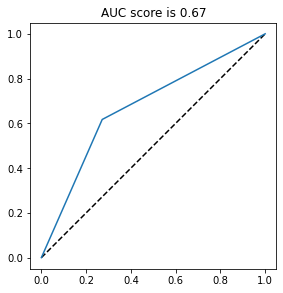

In [31]:
# Roc_Auc_Curve
fpr, tpr, _ = roc_curve(test_data.iloc[:, 0], np.where(predictions > 0.5, 1, 0))
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(test_data.iloc[:, 0], np.where(predictions > 0.5, 1, 0))))
ax.set_aspect(1)
plt.savefig('../Images/AWS SageMaker XGBClassifier ROC-CORVE.png')

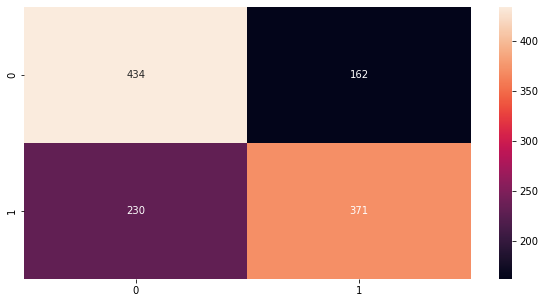

<Figure size 432x288 with 0 Axes>

In [32]:
# Confusion_Matrix
plt.figure(figsize=(10, 5))
cm = confusion_matrix(test_data.iloc[:, 0], np.where(predictions > 0.5, 1, 0))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()
plt.savefig('../Images/AWS SageMaker XGBClassifier Confusion Maxtrix.png')

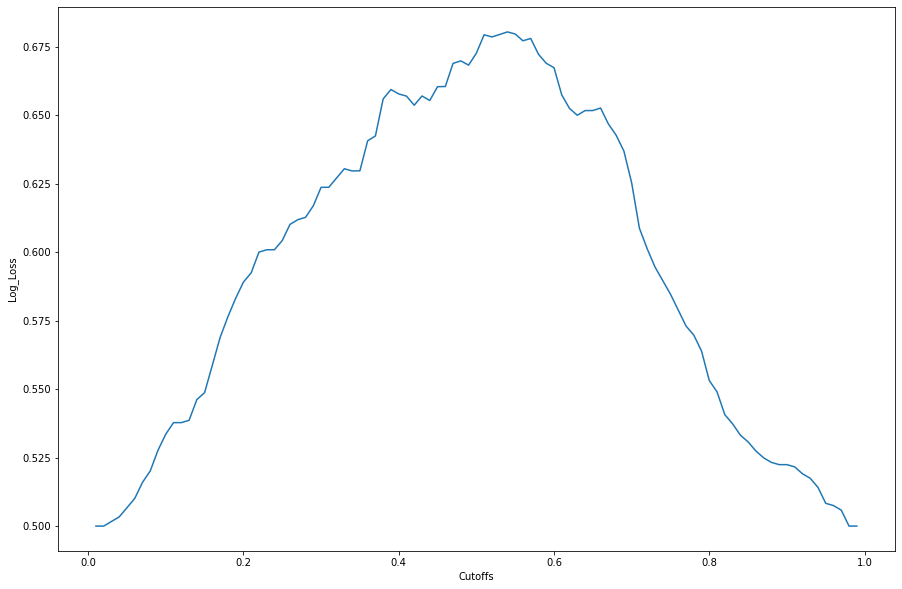

In [21]:
cutoffs = np.arange(0.01, 1, 0.01)
auc = []
for c in cutoffs:
    auc.append(roc_auc_score(test_data.iloc[:, 0], np.where(predictions > c, 1, 0)))

plt.figure(figsize = (15, 10))
plt.plot(cutoffs, auc)
plt.xlabel('Cutoffs')
plt.ylabel('Log_Loss')
plt.show()

In [22]:
print('AUC is minimized at a cufoff of ', cutoffs[np.argmax(auc)], ', and the AUC value at the maximum is ', np.max(auc))

AUC is minimized at a cufoff of  0.54 , and the AUC value at the maximum is  0.6805268623881897


## Testing | World Cup Winner Prediction

### Data – World Cup Rankings Home

In [24]:
WC22_teams = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands',
              'England', 'Iran', 'USA', 'Wales',
              'Argentina', 'Saudi Arabia', 'Mexico', 'Poland', 
              'France', 'Australia', 'Denmark', 'Tunisia',
              'Spain', 'Costa Rica', 'Germany', 'Japan',
              'Belgium', 'Canada', 'Morocco', 'Croatia',
              'Brazil', 'Serbia', 'Switzerland', 'Cameroon',
              'Portugal', 'Ghana', 'Uruguay', 'Korea Republic']

In [25]:
world_cup_rankings_home = df[['home_team','home_team_fifa_rank','home_team_total_fifa_points', 'is_won']].loc[df['home_team'].isin(WC22_teams) & (df['date'] >= '2018-01-01')] #Get last 2 years of information (try to get all time too, get interesting results!)
world_cup_rankings_away = df[['away_team','away_team_fifa_rank','away_team_total_fifa_points', 'is_won']].loc[df['away_team'].isin(WC22_teams)& (df['date'] >= '2018-01-01')]
world_cup_rankings_home = world_cup_rankings_home.set_index(['home_team'])

In [26]:
#The idea is to separete the performance of each Team as Home or Away.
world_cup_rankings_home = world_cup_rankings_home.groupby('home_team').mean()
world_cup_rankings_away = world_cup_rankings_away.groupby('away_team').mean()

In [27]:
world_cup_rankings_home.head(13)

,home_team_fifa_rank,home_team_total_fifa_points,is_won
home_team,,,
Argentina,8.312500,1602.468750,0.593750
Australia,39.111111,1376.333333,0.555556
Belgium,1.727273,1713.939394,0.787879
Brazil,2.810811,1731.324324,0.675676
Cameroon,50.956522,1353.695652,0.478261
Canada,62.470588,1323.588235,0.882353
Costa Rica,42.272727,1393.318182,0.500000
Croatia,11.517241,1580.482759,0.551724
Denmark,11.677419,1511.870968,0.645161


In [28]:
world_cup_rankings_away.head(13)

,away_team_fifa_rank,away_team_total_fifa_points,is_won
away_team,,,
Argentina,7.545455,1588.454545,0.136364
Australia,38.947368,1263.526316,0.315789
Belgium,1.560000,1787.240000,0.160000
Brazil,2.250000,1680.600000,0.000000
Cameroon,49.789474,1301.315789,0.315789
Canada,62.695652,1371.956522,0.347826
Costa Rica,38.911765,1347.823529,0.500000
Croatia,11.642857,1562.642857,0.392857
Denmark,11.500000,1588.230769,0.192308


In [29]:
world_cup_rankings_home.index

Index(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon', 'Canada',
       'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England', 'France',
       'Germany', 'Ghana', 'Japan', 'Korea Republic', 'Mexico', 'Morocco',
       'Netherlands', 'Poland', 'Portugal', 'Qatar', 'Saudi Arabia', 'Senegal',
       'Serbia', 'Spain', 'Switzerland', 'Tunisia', 'USA', 'Uruguay', 'Wales'],
      dtype='object', name='home_team')

#### Qatar World Cup 2022 Group Stage fixtures

In [74]:
groups = pd.read_csv('Groupes - V3.csv')
groups.index += 1
groups.tail()

,team,groups,First match against,Second match against,Third match against
28,Cameroon,G,Switzerland,Serbia,Brazil
29,Portugal,H,Ghana,Uruguay,South Korea
30,Ghana,H,Portugal,South Korea,Uruguay
31,Uruguay,H,South Korea,Portugal,Ghana
32,South Korea,H,Uruguay,Ghana,Portugal


### Creating Qatar World Cup Simulation

In [ ]:
from tqdm import tqdm #SHOW TASK BAR

simulation_winners = list()
simulation_results_winners = list()
simulation_results_round16 = list()
simulation_df_round16 = list()
simulation_results_quarterfinal = list()
simulation_df_quarterfinal = list()
simulation_results_semifinal = list()
simulation_df_semifinal = list()

n_simulations = 2000 #Number of Simulations

for j in tqdm(range(n_simulations)):
    #IMPORTANT: It has to sort the teams in the order of pairs they might go against starting from round_16 (i.e SENEGAL X NETHERLANDS, or FRANCE x DENMARK) - to play around with the matches check https://www.telegraph.co.uk/world-cup/2022-predictor-wallchart-football-qatar/
    #Before the world cup, this first list was my personal opnion which teams would advance to the round_16. Belgium and Germany wore my biggest surprise!
    #candidates = [ 'Senegal', 'Netherlands', 'England','USA', 'Argentina', 'Poland', 'France', 'Denmark','Spain', 'Germany', 'Belgium', 'Croatia', 'Brazil', 'Serbia', 'Portugal','Uruguay']
    #New Update: Official teams that advanced to the round_16 world cup 22! 
    candidates = ['Senegal', 'England', 'Netherlands', 'USA', 
                  'Argentina', 'Australia', 'France', 'Poland', 
                  'Spain', 'Morocco', 'Japan', 'Croatia', 
                  'Brazil', 'Serbia', 'Portugal', 'Switzerland']
    finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']
    
    for f in finals:
        iterations = int(len(candidates) / 2)
        #print('STEP:', iterations) #uncomment to observe in more details the iteraction
        winners = []
        prob = []


        for i in range(iterations):
            home = candidates[i*2]
            away = candidates[i*2+1]
            
            row = pd.DataFrame(np.array([[True, np.nan, np.nan, np.nan]]), columns = X.columns)
            is_won = world_cup_rankings_home.loc[home, 'is_won']
            home_rank = world_cup_rankings_home.loc[home, 'home_team_fifa_rank']
            home_points = world_cup_rankings_home.loc[home, 'home_team_total_fifa_points']
            opp_rank = world_cup_rankings_away.loc[away, 'away_team_fifa_rank']
            opp_points = world_cup_rankings_away.loc[away, 'away_team_total_fifa_points']
            row['is_won'] = is_won
            row['average_rank'] = (home_rank + opp_rank) / 2
            row['rank_difference'] = home_rank - opp_rank
            row['point_difference'] = home_points - opp_points
            home_win_prob = predict(row.to_numpy()[:, 1:])
            
            
            # simulation step based on the probability
            simulated_outcome = np.random.binomial(1, home_win_prob)
            winners.append(away) if simulated_outcome <= 0.5 else winners.append(home)
            prob.append(1 - simulated_outcome) if simulated_outcome <= 0.5 else prob.append(simulated_outcome)
        
        if f == 'round_of_16':
            step_16 = ['round_16'] * 8
            candidates_round_16 = zip(step_16, winners, prob)
            df_candidates_round_16 = pd.DataFrame(candidates_round_16, columns = ['Step','Team','Prob'])
            simulation_df_round16.append(df_candidates_round_16)
            simulation_results_round16.append(winners)

        if f == 'quarterfinal':
            step_quarterfinal = ['quarterfinal'] * 4
            candidates_quarterfinal = zip(step_quarterfinal,winners, prob)
            df_candidates_quarterfinal = pd.DataFrame(candidates_quarterfinal, columns = ['Step','Team','Prob'])
            simulation_df_quarterfinal.append(df_candidates_quarterfinal)
            simulation_results_quarterfinal.append(winners)

        if f == 'semifinal':    
            step_semifinal = ['semifinal'] * 2
            candidates_semifinal = zip(step_semifinal,winners, prob)
            df_candidates_semifinal = pd.DataFrame(candidates_semifinal, columns = ['Step','Team','Prob'])
            simulation_df_semifinal.append(df_candidates_semifinal)
            simulation_results_semifinal.append(winners)

        if f == 'final':    
            step_final = ['final'] * 1
            candidates_final = zip(step_final,winners, prob)
            df_candidates_final = pd.DataFrame(candidates_final, columns = ['Step','Team','Prob'])
            simulation_winners.append(df_candidates_final)
            simulation_results_winners.append(winners)
            
        candidates = winners 

df_candidates_round_16 = pd.concat(simulation_df_round16)
df_candidates_quarterfinal = pd.concat(simulation_df_quarterfinal)
df_candidates_semifinal = pd.concat(simulation_df_semifinal)
df_candidates_final = pd.concat(simulation_winners)

df_results = pd.concat([df_candidates_round_16,df_candidates_quarterfinal,df_candidates_semifinal,df_candidates_final]) #final DataFrame

simulation_results_round16 = sum(simulation_results_round16, [])
simulation_results_quarterfinal = sum(simulation_results_quarterfinal, [])
simulation_results_semifinal = sum(simulation_results_semifinal, [])
simulations_winners = sum(simulation_results_winners, [])


100%|██████████| 2000/2000 [04:23<00:00,  7.59it/s]


### Creating 2022 Qatar World Cup Simulation / Prediction

In [38]:
from tqdm import tqdm #SHOW TASK BAR

simulation_winners = list()
simulation_results_winners = list()
simulation_results_round16 = list()
simulation_df_round16 = list()
simulation_results_quarterfinal = list()
simulation_df_quarterfinal = list()
simulation_results_semifinal = list()
simulation_df_semifinal = list()

n_simulations = 1000 #Number of Simulations

for j in tqdm(range(n_simulations)):
    #IMPORTANT: It has to sort the teams in the order of pairs they might go against starting from round_16 (i.e SENEGAL X NETHERLANDS, or FRANCE x DENMARK) - to play around with the matches check https://www.telegraph.co.uk/world-cup/2022-predictor-wallchart-football-qatar/
    #Before the world cup, this first list was my personal opnion which teams would advance to the round_16. Belgium and Germany wore my biggest surprise!
    #candidates = [ 'Senegal', 'Netherlands', 'England','USA', 'Argentina', 'Poland', 'France', 'Denmark','Spain', 'Germany', 'Belgium', 'Croatia', 'Brazil', 'Serbia', 'Portugal','Uruguay']
    #New Update: Official teams that advanced to the round_16 world cup 22! 
    candidates = [ 'Senegal','England','Netherlands','USA', 'Argentina','Australia', 'France', 'Poland','Spain', 'Morocco', 'Japan', 'Croatia', 'Brazil', 'Serbia', 'Portugal','Switzerland']
    finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']
    
    for f in finals:
        iterations = int(len(candidates) / 2)
        #print('STEP:', iterations) #uncomment to observe in more details the iteraction
        winners = []
        prob = []


        for i in range(iterations):
            home = candidates[i*2]
            away = candidates[i*2+1]
            
            row = pd.DataFrame(np.array([[True, np.nan, np.nan, np.nan]]), columns = X_test.columns)
            is_won = world_cup_rankings_home.loc[home, 'is_won']
            home_rank = world_cup_rankings_home.loc[home, 'home_team_fifa_rank']
            home_points = world_cup_rankings_home.loc[home, 'home_team_total_fifa_points']
            opp_rank = world_cup_rankings_away.loc[away, 'away_team_fifa_rank']
            opp_points = world_cup_rankings_away.loc[away, 'away_team_total_fifa_points']
            row['is_won'] = is_won
            row['average_rank'] = (home_rank + opp_rank) / 2
            row['rank_difference'] = home_rank - opp_rank
            row['point_difference'] = home_points - opp_points
            home_win_prob = predict(row.to_numpy()[:, 1:])
            # home_win_prob = model.predict_proba(row)[:,1][0]
            
            # simulation step based on the probability
            simulated_outcome = np.random.binomial(1, home_win_prob)
            winners.append(away) if simulated_outcome <= 0.5 else winners.append(home)
            prob.append(1 - simulated_outcome) if simulated_outcome <= 0.5 else prob.append(simulated_outcome)
        
        if f == 'round_of_16':
            step_16 = ['round_16'] * 8
            candidates_round_16 = zip(step_16, winners, prob)
            df_candidates_round_16 = pd.DataFrame(candidates_round_16, columns = ['Step','Team','Prob'])
            simulation_df_round16.append(df_candidates_round_16)
            simulation_results_round16.append(winners)

        if f == 'quarterfinal':
            step_quarterfinal = ['quarterfinal'] * 4
            candidates_quarterfinal = zip(step_quarterfinal,winners, prob)
            df_candidates_quarterfinal = pd.DataFrame(candidates_quarterfinal, columns = ['Step','Team','Prob'])
            simulation_df_quarterfinal.append(df_candidates_quarterfinal)
            simulation_results_quarterfinal.append(winners)

        if f == 'semifinal':    
            step_semifinal = ['semifinal'] * 2
            candidates_semifinal = zip(step_semifinal,winners, prob)
            df_candidates_semifinal = pd.DataFrame(candidates_semifinal, columns = ['Step','Team','Prob'])
            simulation_df_semifinal.append(df_candidates_semifinal)
            simulation_results_semifinal.append(winners)

        if f == 'final':    
            step_final = ['final'] * 1
            candidates_final = zip(step_final,winners, prob)
            df_candidates_final = pd.DataFrame(candidates_final, columns = ['Step','Team','Prob'])
            simulation_winners.append(df_candidates_final)
            simulation_results_winners.append(winners)

        
        #uncomment to observe every result of each step and iteration
        #list_win = list(zip(winners,prob))
        #print(list_win)
        candidates = winners 

df_candidates_round_16 = pd.concat(simulation_df_round16)
df_candidates_quarterfinal = pd.concat(simulation_df_quarterfinal)
df_candidates_semifinal = pd.concat(simulation_df_semifinal)
df_candidates_final = pd.concat(simulation_winners)

df_results = pd.concat([df_candidates_round_16,df_candidates_quarterfinal,df_candidates_semifinal,df_candidates_final]) #final DataFrame

simulation_results_round16 = sum(simulation_results_round16, [])
simulation_results_quarterfinal = sum(simulation_results_quarterfinal, [])
simulation_results_semifinal = sum(simulation_results_semifinal, [])
simulations_winners = sum(simulation_results_winners, [])


100%|██████████| 1000/1000 [00:51<00:00, 19.55it/s]


### Generating results as plots of the stages till Final

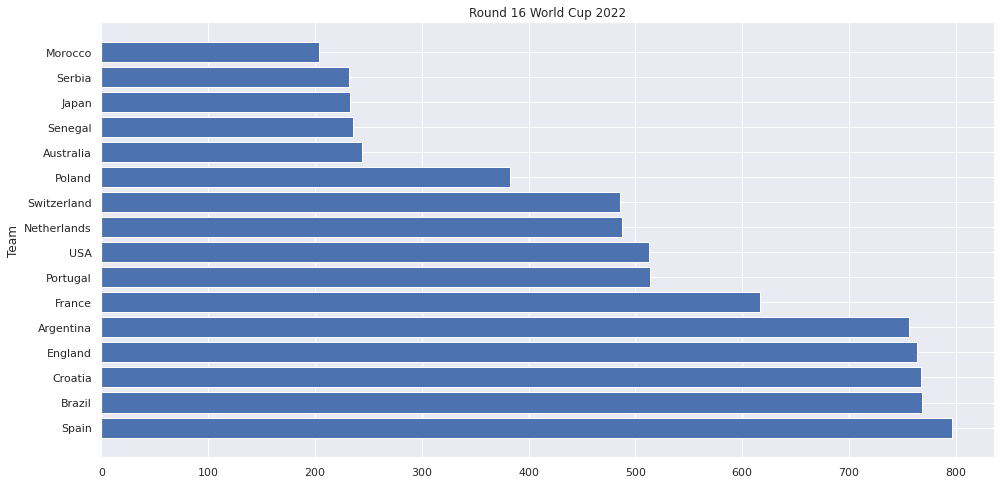

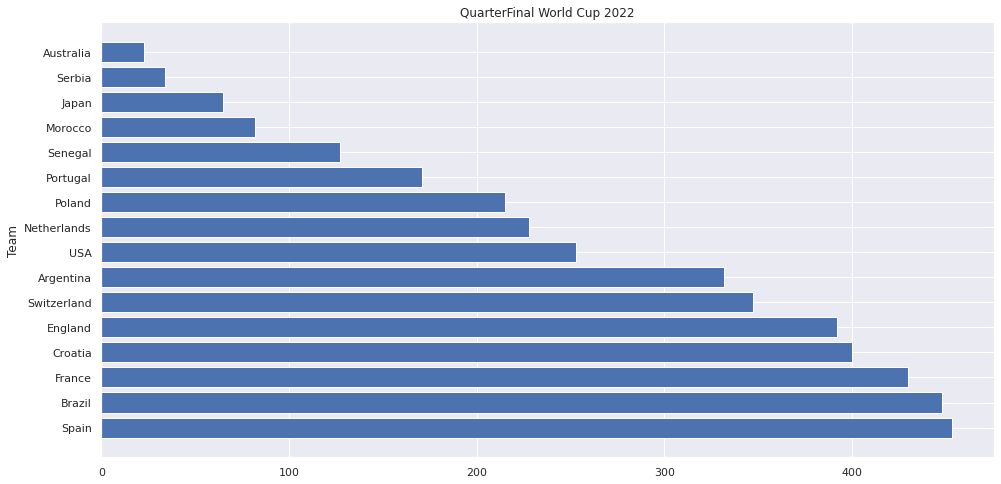

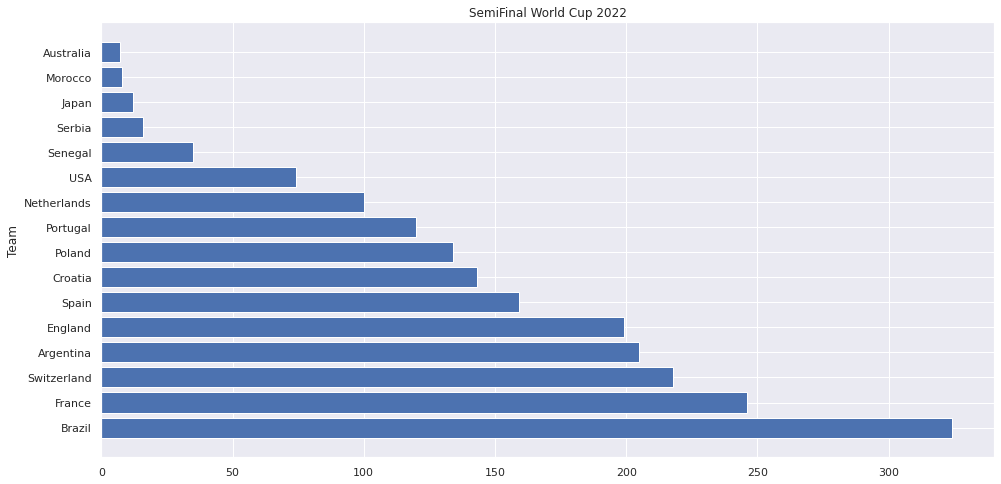

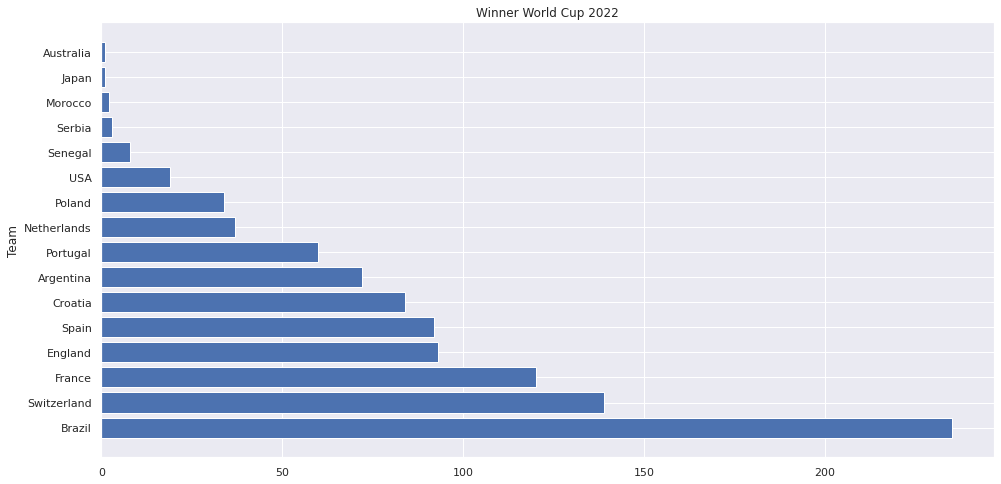

In [40]:
from collections import Counter
from matplotlib import figure

lst_results = [simulation_results_round16,simulation_results_quarterfinal,simulation_results_semifinal,simulations_winners]
for i in lst_results:
    results = Counter(i).most_common()
    x,y = zip(*results)

    fig,ax = plt.subplots(figsize=(16,8))

    ax.barh(x, y)

    ax.set_ylabel('Team')

    if i == simulation_results_round16:
        ax.set_title('Round 16 World Cup 2022')
    if i == simulation_results_quarterfinal:
        ax.set_title('QuarterFinal World Cup 2022')
    if i == simulation_results_semifinal:
        ax.set_title('SemiFinal World Cup 2022')
    if i == simulations_winners:
        ax.set_title('Winner World Cup 2022')

        
    plt.show()

### Top 6 Teams to win the 2022 Qatar World Cup

In [39]:
winner = pd.DataFrame(results, columns = ['Country/Team', 'Win %'])
winner.index += 1
winner['Win %'] = (np.round((winner['Win %'] / winner['Win %'].sum()).mul(100), 3)).astype('str') + '%'
winner.head(7)

,Country/Team,Win %
1,Brazil,17.5%
2,France,13.5%
3,Croatia,11.2%
4,Portugal,11.15%
5,Switzerland,8.7%
6,Spain,8.1%
7,Argentina,6.95%


### Deleting the Endpoint

In [79]:
sagemaker.Session().delete_endpoint(predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: xgboost-2023-01-03-00-27-57-004
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


[{'ResponseMetadata': {'RequestId': 'DAXYQVS5VVR7GR3R',
   'HostId': 'f8OkYK5J6HSXgQdj6F66gLdrlfZq94rhZoi+IJW/YbfuK/XOl5AgX5VH63rKKHynP19GNCNnQcU=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'f8OkYK5J6HSXgQdj6F66gLdrlfZq94rhZoi+IJW/YbfuK/XOl5AgX5VH63rKKHynP19GNCNnQcU=',
    'x-amz-request-id': 'DAXYQVS5VVR7GR3R',
    'date': 'Tue, 03 Jan 2023 00:33:14 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'model/xgboost-2023-01-02-23-35-43-864/profiler-output/system/training_job_end.ts'},
   {'Key': 'model/sagemaker-xgboost-2023-01-02-23-23-22-411/debug-output/events/000000000340/000000000340_worker_0.tfevents'},
   {'Key': 'model/sagemaker-xgboost-2023-01-02-23-23-22-411/debug-output/index/000000000/000000000060_worker_0.json'},
   {'Key': 'model/xgboost-2023-01-03-00-08-05-144/profiler-output/system/training_job_end.ts'},
   {'Key': 'model/sag